In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import numpy as np
import dask.array as da
import xarray as xr
import os

from xmitgcm import open_mdsdataset
import xmitgcm
import sys
import ecco_v4_py as ecco

from netCDF4 import Dataset

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import ecco_masks
from analysis_package import calculate_isovol

from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary

In [4]:
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################
grid_path = "./ECCO-GRID.nc"
grid = xr.open_dataset(grid_path)
cds = grid.coords.to_dataset()
grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)

######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################
maskW = xr.open_dataarray("generic_masks/maskW.nc")
maskS = xr.open_dataarray("generic_masks/maskS.nc")
maskC = xr.open_dataarray("generic_masks/maskC.nc")

southern_ocean_mask_W, southern_ocean_mask_S, southern_ocean_mask_C, so_atl_basin_mask_W, so_atl_basin_mask_S, so_atl_basin_mask_C, so_indpac_basin_mask_W, so_indpac_basin_mask_S, so_indpac_basin_mask_C = ecco_masks.get_basin_masks(maskW, maskS, maskC)

baffin_mask_C = ecco.get_basin_mask("baffin",maskC)
north_mask_C = ecco.get_basin_mask("north",maskC)
hudson_mask_C = ecco.get_basin_mask("hudson",maskC)
gin_mask_C = ecco.get_basin_mask("gin",maskC)
bering_mask_C = ecco.get_basin_mask("bering",maskC)
okhotsk_mask_C = ecco.get_basin_mask("okhotsk",maskC)
atl_mask_C = ecco.get_basin_mask("atl",maskC)

hudson_mask_C = ecco.get_basin_mask("hudson",maskC)
baffin_mask_C = ecco.get_basin_mask("baffin",maskC)

atl_nogin_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat>-32,other=np.nan).where((gin_mask_C+north_mask_C < 1).values,other=np.nan)

atl_nogin_nolab_basin_mask_C = atl_nogin_basin_mask_C.where(atl_nogin_basin_mask_C.lat>-32,other=np.nan).where((hudson_mask_C < 1).values,other=np.nan)

indpac_basin_mask_C = so_indpac_basin_mask_C.where(so_indpac_basin_mask_C.lat>=-32,other=np.nan)
so_basin_mask_C = so_indpac_basin_mask_C.where(so_indpac_basin_mask_C.lat<-32,other=np.nan)


atl_midlat_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat<=50,other=np.nan).where(so_atl_basin_mask_C.lat>=-32,other=np.nan)




load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary

In [5]:
SIGMA2 = xr.open_dataarray(f"SIGMA2_full.nc")
SIGMA2_yearly = xr.open_dataarray(f"SIGMA2_yearly.nc")

In [6]:


sigma2_lvls = [1036.95,1037.053]

# Values for "tiles", "i_vals", and "j_vals" are 
tiles=np.arange(0,13)
i_vals=np.arange(0,90)
j_vals=np.arange(0,90)
time=np.arange(0,26)
# set dimensions based on input dataset with sigma-space vertical levels..
ntv_pdens_dims = (len(tiles),
                 len(sigma2_lvls),
                 len(j_vals),
                 len(i_vals),
                 )
new_coords = [tiles,sigma2_lvls,i_vals,j_vals]
new_dims = ["tile","sig","j","i",]

vol_sig_interp_out = xr.DataArray(data=np.zeros(ntv_pdens_dims),coords=new_coords,dims=new_dims)



ntv_pdens_dims_time = (len(tiles),
                         len(sigma2_lvls),
                         len(j_vals),
                         len(i_vals),
                         len(time)
                         )
new_coords_time = [tiles,sigma2_lvls,i_vals,j_vals,time]
new_dims_time = ["tile","sig","j","i","time"]

vol_sig_interp_out_time = xr.DataArray(data=np.zeros(ntv_pdens_dims_time),coords=new_coords_time,dims=new_dims_time)


SIGMA2vol_0_interp = calculate_isovol.sigma2_volume_simple_interp(sigma2_lvls,SIGMA2.isel(time=0),grid,vol_sig_interp_out.copy(),time=False,lessthan=True)
SIGMA2vol_1_interp = calculate_isovol.sigma2_volume_simple_interp(sigma2_lvls,SIGMA2.isel(time=-1),grid,vol_sig_interp_out.copy(),time=False,lessthan=True)
SIGMA2vol_yearly_interp = calculate_isovol.sigma2_volume_simple_interp(sigma2_lvls,SIGMA2_yearly,grid,vol_sig_interp_out_time.copy(),time=True,lessthan=True)




1036.95 1037.053 1036.95 1037.053 1036.95 1037.053 

In [7]:
############################################################################################################
#############################################     LOAD DATA    #############################################
############################################################################################################
SIGMA2_maxsurf = SIGMA2_yearly.max(dim="time")
SIGMA2_maxsurf = SIGMA2_maxsurf.where(SIGMA2_maxsurf>1036).isel(k=0)



In [31]:
strfnc_path = "./"
min_potrho=0
max_potrho=48

AMOC_SIGMA2 = xr.open_dataarray(strfnc_path+"AMOC_sig2.nc")
IPMOC_SIGMA2 = xr.open_dataarray(strfnc_path+"IPMOC_sig2.nc")


amoc_botsurf_N = xr.open_dataarray("amoc_botsurf_N.nc")
amoc_botsurf_S = xr.open_dataarray("amoc_botsurf_S.nc")
# flip pot_rho dimensions
amoc_botsurf_S = amoc_botsurf_S.reindex(sig=list(reversed(amoc_botsurf_S.sig)))

ipmoc_botsurf_N = xr.open_dataarray("ipmoc_botsurf_N.nc")
ipmoc_botsurf_S = xr.open_dataarray("ipmoc_botsurf_S.nc")
# flip pot_rho dimensions
ipmoc_botsurf_S = ipmoc_botsurf_S.reindex(sig=list(reversed(ipmoc_botsurf_S.sig)))


amoc_N_interp = amoc_botsurf_N[:-2].interp(sig=AMOC_SIGMA2.sig[min_potrho:max_potrho])
amoc_S_interp = amoc_botsurf_S.interp(sig=AMOC_SIGMA2.sig[min_potrho:max_potrho])

ipmoc_N_interp = ipmoc_botsurf_N[:-2].interp(sig=AMOC_SIGMA2.sig[min_potrho:max_potrho])
ipmoc_S_interp = ipmoc_botsurf_S.interp(sig=AMOC_SIGMA2.sig[min_potrho:max_potrho])



In [33]:

atl_iso_V_yrly = (so_atl_basin_mask_C*SIGMA2vol_yearly_interp)
indpac_iso_V_yrly = (so_indpac_basin_mask_C*SIGMA2vol_yearly_interp)
so_iso_V_yrly = (so_atl_basin_mask_C*SIGMA2vol_yearly_interp)

for lat in np.arange(35,88):
    print(lat, end=" ")
    amoc_N_interp_max = amoc_N_interp.sig.where(amoc_N_interp.lat>=lat).min()
    ipmoc_N_interp_max = ipmoc_N_interp.sig.where(ipmoc_N_interp.lat>=lat).min()
    
    atl_iso_V_yrly = atl_iso_V_yrly.where((atl_iso_V_yrly.sig >= amoc_N_interp_max) & (so_atl_basin_mask_C.lat >= lat) | ( so_atl_basin_mask_C.lat < lat), other=0)
    indpac_iso_V_yrly = indpac_iso_V_yrly.where((indpac_iso_V_yrly.sig >= ipmoc_N_interp_max) & (so_indpac_basin_mask_C.lat >= lat) | ( so_indpac_basin_mask_C.lat < lat), other=0)

for lat in np.arange(-88,-31):
    print(lat, end=" ")
    amoc_S_interp_max = amoc_S_interp.sig.where(amoc_S_interp.lat<=lat).min()
    so_iso_V_yrly = so_iso_V_yrly.where((so_iso_V_yrly.sig >= amoc_S_interp_max) & (so_atl_basin_mask_C.lat <= lat) | ( so_atl_basin_mask_C.lat > lat), other=0)



35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 

-88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 

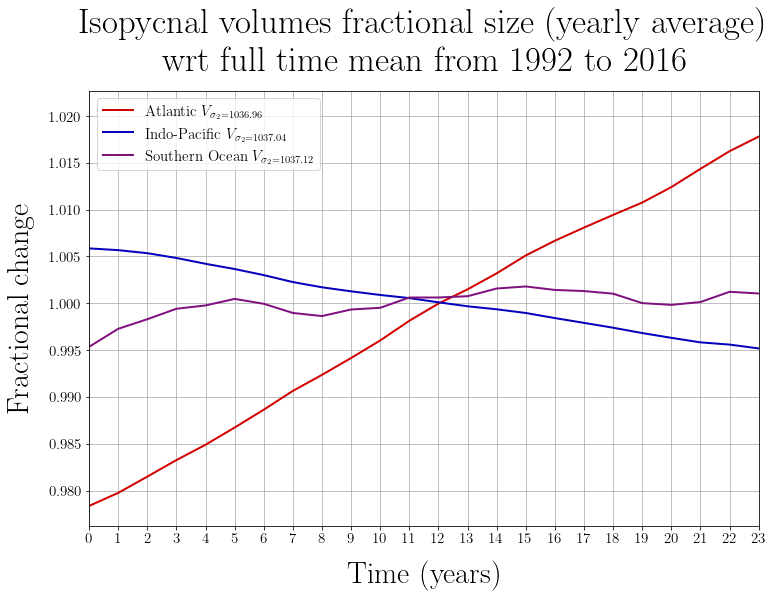

In [38]:

atl_iso_V_yrly = (atl_midlat_basin_mask_C*SIGMA2vol_yearly_interp)
indpac_iso_V_yrly = (indpac_basin_mask_C*SIGMA2vol_yearly_interp)
so_iso_V_yrly = (so_basin_mask_C*SIGMA2vol_yearly_interp)


atl_iso_V_yrly_2d = (atl_midlat_basin_mask_C*SIGMA2vol_yearly_interp).sum(dim=["tile","i","j"])
indpac_iso_V_yrly_2d = (indpac_basin_mask_C*SIGMA2vol_yearly_interp).sum(dim=["tile","i","j"])
so_iso_V_yrly_2d = (so_basin_mask_C*SIGMA2vol_yearly_interp).sum(dim=["tile","i","j"])


for lat in np.arange(-88,-31):
    print(lat, end=" ")
    amoc_S_interp_max = amoc_S_interp.sig.where(amoc_S_interp.lat<=lat).min()
    so_iso_V_yrly = so_iso_V_yrly.where((so_iso_V_yrly.sig >= amoc_S_interp_max) & (so_atl_basin_mask_C.lat <= lat) | ( so_atl_basin_mask_C.lat > lat), other=0)

so_iso_V_yrly_2d = (so_basin_mask_C*so_iso_V_yrly).sum(dim=["tile","i","j"])

for lat in np.arange(-88,-31):
    print(lat, end=" ")
    amoc_S_interp_max = amoc_S_interp.sig.where(amoc_S_interp.lat<=lat).min()
    so_iso_V_yrly = so_iso_V_yrly.where((so_iso_V_yrly.sig >= amoc_S_interp_max) & (so_atl_basin_mask_C.lat <= lat) | ( so_atl_basin_mask_C.lat > lat), other=0)



tmp_plt_atl = (atl_iso_V_yrly_2d.isel(sig=0).mean(dim="time") - atl_iso_V_yrly_2d.isel(sig=0))/atl_iso_V_yrly_2d.isel(sig=0).mean(dim="time")
tmp_plt_indpac = (indpac_iso_V_yrly_2d.isel(sig=0).mean(dim="time") - indpac_iso_V_yrly_2d.isel(sig=0))/indpac_iso_V_yrly_2d.isel(sig=0).mean(dim="time")
tmp_plt_so = (so_iso_V_yrly_2d.isel(sig=0).mean(dim="time") - so_iso_V_yrly_2d.isel(sig=0))/so_iso_V_yrly_2d.isel(sig=0).mean(dim="time")

plt.figure(figsize=(12,8))
plt.plot(tmp_plt_atl.time,1+tmp_plt_atl,label="Atlantic $V_{\sigma_{2}=1036.96}$ % Volume Change",linewidth=2,color="#D20000")
plt.plot(tmp_plt_indpac.time,1+tmp_plt_indpac,label="Indo-Pacific $V_{\sigma_{2}=1037.04}$ % Volume Change",linewidth=2,color="#0400BB")
plt.plot(tmp_plt_so.time,1-tmp_plt_so,label="Southern Ocean $V_{\sigma_{2}=1037.12}$ % Volume Change",linewidth=2,color="#7F127E")
plt.title("Isopycnal volumes fractional size (yearly average) \n wrt full time mean from 1992 to 2016",fontsize=35,pad=20)
plt.yticks(np.arange(0.98,1.02,0.005),fontsize=15)
plt.xticks(tmp_plt_indpac.time,fontsize=15)
plt.xlim((0,23))
plt.xlabel("Time (years)",fontsize=30,labelpad=15)
plt.ylabel("Fractional change",fontsize=30,labelpad=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()
plt.close()


In [15]:
indpac_iso_V_yrly_tdiff_tsum = indpac_iso_V_yrly.diff(dim="time").sum(dim="time")/((754704000-2592000))
atl_iso_V_yrly_tdiff_tsum = atl_iso_V_yrly.diff(dim="time").sum(dim="time")/((754704000-2592000))
so_iso_V_yrly_tdiff_tsum = so_iso_V_yrly.diff(dim="time").sum(dim="time")/((754704000-2592000))
iso_V_yrly_tdiff_tsum = iso_V_yrly.diff(dim="time").sum(dim="time")/((754704000-2592000))


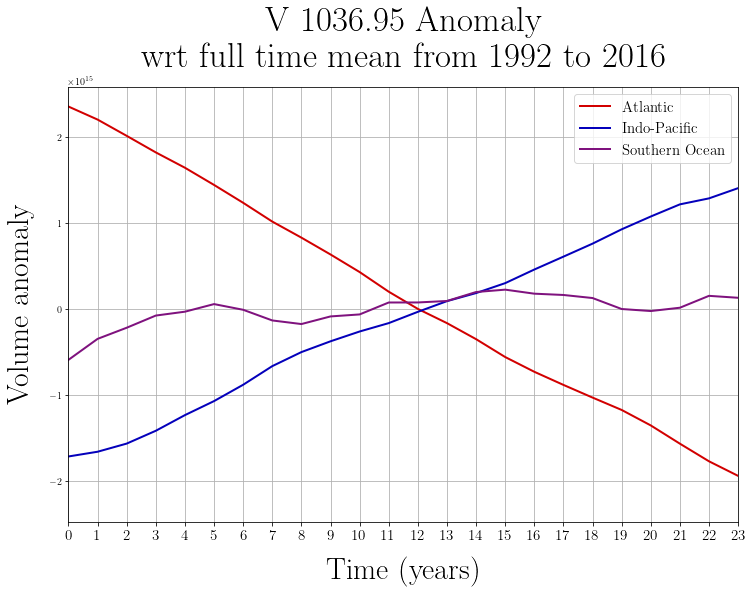

In [40]:
tmp_sig = 0
tmp_plt_atl = (atl_iso_V_yrly_2d.isel(sig=tmp_sig)-atl_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time"))
tmp_plt_indpac = (indpac_iso_V_yrly_2d.isel(sig=tmp_sig)-indpac_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )
tmp_plt_so = (so_iso_V_yrly_2d.isel(sig=tmp_sig)-so_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )

plt.figure(figsize=(12,8))
plt.plot(tmp_plt_atl.time,tmp_plt_atl,label="Atlantic",linewidth=2,color="#D20000")
plt.plot(tmp_plt_indpac.time,tmp_plt_indpac,label="Indo-Pacific",linewidth=2,color="#0400BB")
plt.plot(tmp_plt_so.time,tmp_plt_so,label="Southern Ocean",linewidth=2,color="#7F127E")
plt.title("V "+str(atl_iso_V_yrly_2d.sig[tmp_sig].values)+" Anomaly \n wrt full time mean from 1992 to 2016",fontsize=35,pad=20)
plt.xticks(tmp_plt_indpac.time,fontsize=15)
plt.xlim((0,23))
plt.xlabel("Time (years)",fontsize=30,labelpad=15)
plt.ylabel("Volume anomaly",fontsize=30,labelpad=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()
plt.close()

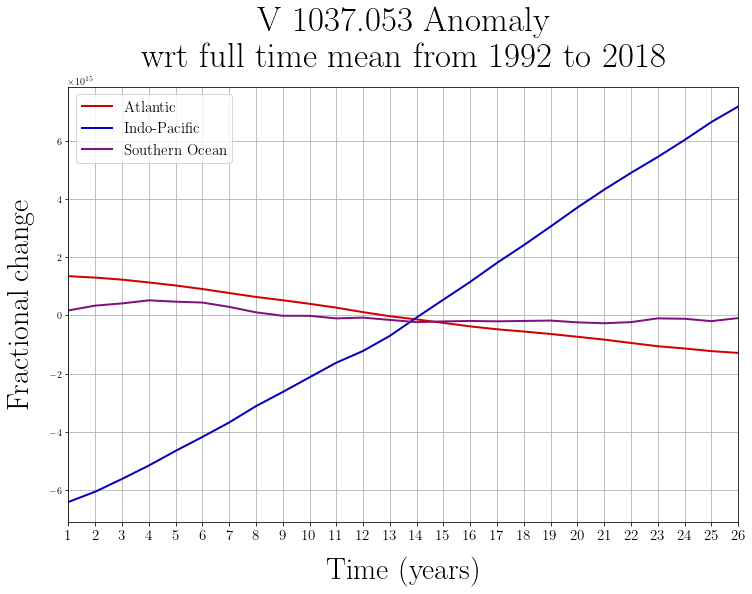

In [48]:
tmp_sig = 1
tmp_plt_atl = (atl_iso_V_yrly_2d.isel(sig=tmp_sig)-atl_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time"))
tmp_plt_indpac = (indpac_iso_V_yrly_2d.isel(sig=tmp_sig)-indpac_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )
tmp_plt_so = (so_iso_V_yrly_2d.isel(sig=tmp_sig)-so_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )

plt.figure(figsize=(12,8))
plt.plot(tmp_plt_atl.time,tmp_plt_atl,label="Atlantic",linewidth=2,color="#D20000")
plt.plot(tmp_plt_indpac.time,tmp_plt_indpac,label="Indo-Pacific",linewidth=2,color="#0400BB")
plt.plot(tmp_plt_so.time,tmp_plt_so,label="Southern Ocean",linewidth=2,color="#7F127E")
plt.title("V "+str(atl_iso_V_yrly_2d.sig[tmp_sig].values)+" Anomaly \n wrt full time mean from 1992 to 2018",fontsize=35,pad=20)
plt.xticks(range(0,26),tmp_plt_indpac.time.values+1,fontsize=15)
plt.xlim((0,25))
plt.xlabel("Time (years)",fontsize=30,labelpad=15)
plt.ylabel("Fractional change",fontsize=30,labelpad=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()
plt.close()

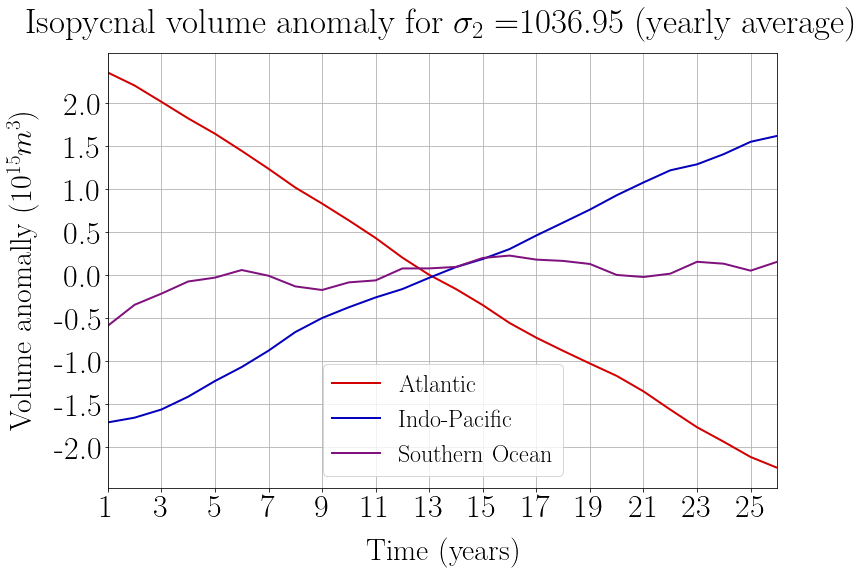

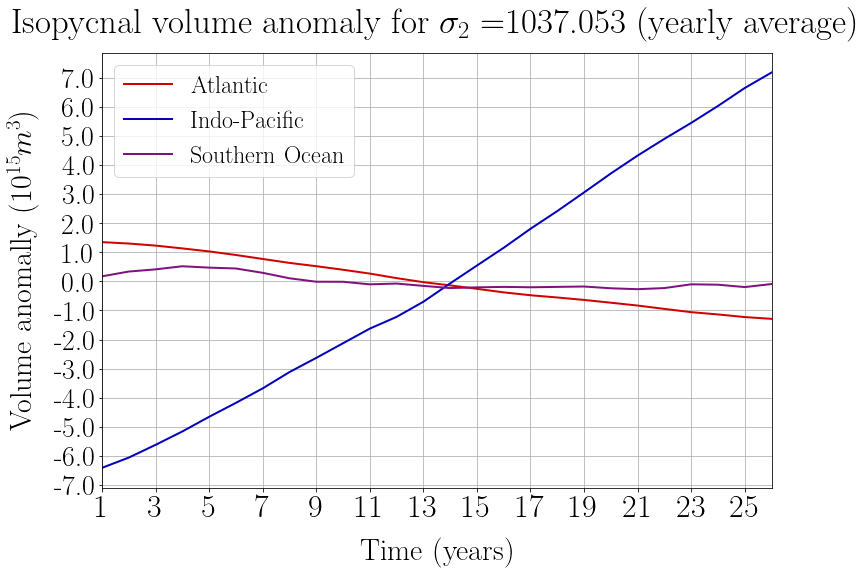

In [56]:
ytick_fontsize=32
xtick_fontsize=32

tmp_sig = 0
tmp_plt_atl = (atl_iso_V_yrly_2d.isel(sig=tmp_sig)-atl_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time"))
tmp_plt_indpac = (indpac_iso_V_yrly_2d.isel(sig=tmp_sig)-indpac_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )
tmp_plt_so = (so_iso_V_yrly_2d.isel(sig=tmp_sig)-so_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )

plt.figure(figsize=(12,8))
plt.plot(tmp_plt_atl.time,tmp_plt_atl,label="Atlantic",linewidth=2,color="#D20000")
plt.plot(tmp_plt_indpac.time,tmp_plt_indpac,label="Indo-Pacific",linewidth=2,color="#0400BB")
plt.plot(tmp_plt_so.time,tmp_plt_so,label="Southern Ocean",linewidth=2,color="#7F127E")
plt.title("Isopycnal volume anomaly for $\sigma_{2}=$"+str(atl_iso_V_yrly_2d.sig[tmp_sig].values)+" (yearly average)",fontsize=35,pad=20)
plt.yticks(np.arange(-2e15,2.1e15,0.5e15),np.arange(-2,2.1,0.5),fontsize=ytick_fontsize)
plt.xticks(np.arange(0,26,2),np.arange(1,27,2),fontsize=xtick_fontsize)
plt.xlim((0,25))
plt.xlabel("Time (years)",fontsize=30,labelpad=15)
plt.ylabel("Volume anomally ($10^{15}m^{3}$)",fontsize=30,labelpad=15)
plt.legend(fontsize=24)
plt.grid()
plt.show()
plt.close()

tmp_sig = 1
tmp_plt_atl = (atl_iso_V_yrly_2d.isel(sig=tmp_sig)-atl_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time"))
tmp_plt_indpac = (indpac_iso_V_yrly_2d.isel(sig=tmp_sig)-indpac_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )
tmp_plt_so = (so_iso_V_yrly_2d.isel(sig=tmp_sig)-so_iso_V_yrly_2d.isel(sig=tmp_sig).mean(dim="time") )

plt.figure(figsize=(12,8))
plt.plot(tmp_plt_atl.time,tmp_plt_atl,label="Atlantic",linewidth=2,color="#D20000")
plt.plot(tmp_plt_indpac.time,tmp_plt_indpac,label="Indo-Pacific",linewidth=2,color="#0400BB")
plt.plot(tmp_plt_so.time,tmp_plt_so,label="Southern Ocean",linewidth=2,color="#7F127E")
plt.title("Isopycnal volume anomaly for $\sigma_{2}=$"+str(atl_iso_V_yrly_2d.sig[tmp_sig].values)+" (yearly average)",fontsize=35,pad=20)
plt.yticks(np.arange(-7e15,7.1e15,1e15),np.arange(-7,7.1,1.),fontsize=ytick_fontsize-4)
plt.xticks(np.arange(0,26,2),np.arange(1,27,2),fontsize=xtick_fontsize)
plt.xlim((0,25))
plt.xlabel("Time (years)",fontsize=30,labelpad=15)
plt.ylabel("Volume anomally ($10^{15}m^{3}$)",fontsize=30,labelpad=15)
plt.legend(fontsize=24)
plt.grid()
plt.show()
plt.close()
